#Integrantes de la tarea

Integrantes del grupo:

* Integrante 1:Matias Rodriguez U. Rut: 18362815-1
* Integrante 2:Paula Canales G. Rut:18845155-1
* Integrante 3:Sebastián Alday Rut:18294095-k
* Integrante 4:Álvaro Neira R. Rut:13757209-5

# Importación de Librerias

Estas son las bibliotecas y módulos necesarios.

In [ ]:
import pandas as pd
import re

import spacy
import nltk
import sklearn
import wordcloud
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import json
from sklearn.model_selection import train_test_split

# Datos Necesarios

Descargamos los datos necesarios para las actividades

In [ ]:
!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen.csv
#!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen_corto.csv
#!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/proveedoresA.txt
#!wget https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/other_vhosts_access.log
nltk.download('stopwords')
nltk.download('wordnet')
!python -m spacy download es_core_news_sm
import es_core_news_sm
nlp_es = es_core_news_sm.load()

--2021-12-04 18:23:09--  https://raw.githubusercontent.com/fvillena/dcc-ia-nlp/master/data/aysen.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29482924 (28M) [text/plain]
Saving to: ‘aysen.csv’

aysen.csv           100%[===================>]  28.12M  --.-KB/s    in 0.1s    

2021-12-04 18:23:11 (212 MB/s) - ‘aysen.csv’ saved [29482924/29482924]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 16.2 MB 3.5 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=072429246556b270567ceb7fbfd4b8f7

# 1 Limpieza de la base de datos 


##Dataset

In [ ]:
aysen = pd.read_csv("aysen.csv", sep=";", na_values=["Otro",""])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
aysen.head()

,FECHA_NAC,SEXO,PRESTA_MIN,PLANO,EXTREMIDAD,PRESTA_EST,F_ENTRADA,ESTAB_ORIG,ESTAB_DEST,F_SALIDA,C_SALIDA,E_OTOR_AT,PRESTA_MIN_SALIDA,REGION,COMUNA,SOSPECHA_DIAG
0,1985,2,09-001-0,NaN,NaN,ENDODONCIA,31-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Celulitis y absceso de boca
1,1946,1,09-004-0,NaN,NaN,PERIODONCIA,31-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Periodontitis cronica
2,1937,2,09-006-0,NaN,NaN,REHABILITACION: PROTESIS REMOVIBLE,31-12-17,25-301,25-100,2018-01-03 00:00:00,1.0,25-100,09-006-0,11,11101,Otras afecciones especificadas de los dientes ...
3,1955,2,07-208-0,NaN,NaN,NEUROCIRUGIA,30-12-17,25-300,25-100,NaN,NaN,NaN,NaN,11,11101,"Trastornos de disco lumbar y otros, con radicu..."
4,1997,2,09-001-0,NaN,NaN,ENDODONCIA,30-12-17,25-301,25-100,NaN,NaN,NaN,NaN,11,11101,Celulitis y absceso de boca


##1.1 Creación del DK10

###Especialidades con más de 10.000 derivaciones

In [ ]:
D10K_ranking=pd.DataFrame(aysen[["SOSPECHA_DIAG","PRESTA_EST"]].PRESTA_EST.value_counts(dropna=False))
D10K_ranking=D10K_ranking.loc[D10K_ranking["PRESTA_EST"]>10000]
D10K_ranking


,PRESTA_EST
TRAUMATOLOGIA,24004
OFTALMOLOGIA,21482
CIRUGIA ADULTO,17321
OTORRINOLARINGOLOGIA,13663
NEUROLOGIA,12316
MEDICINA INTERNA,11408
GINECOLOGIA,10871
ENDODONCIA,10225


In [ ]:
list(D10K_ranking.index)

['TRAUMATOLOGIA',
 'OFTALMOLOGIA',
 'CIRUGIA ADULTO',
 'OTORRINOLARINGOLOGIA',
 'NEUROLOGIA',
 'MEDICINA INTERNA',
 'GINECOLOGIA',
 'ENDODONCIA']

###Definición DK10

Se necesita de un ciclo para recuperar la columna "SOSPECHA_DIAG" a partir de las especialidades seleccionadas por el rankin

In [ ]:

z1=0
z2=0
presta=[]
sospecha=[]
for u in aysen["PRESTA_EST"]:
  for v in list(D10K_ranking.index):
    if u==v:
      #print(u)
      presta.append(u)
      sospecha.append(aysen["SOSPECHA_DIAG"].iloc[z1])
    z2=z2+1 
  z1=z1+1

Se concatenan y se crea DK10

In [ ]:
DK10=pd.concat([pd.DataFrame(sospecha).rename(columns={0:"SOSPECHA_DIAG"}),pd.DataFrame(presta).rename(columns={0:"PRESTA_EST"})],axis=1)
DK10=DK10.reset_index(drop=True)

In [ ]:
DK10

,SOSPECHA_DIAG,PRESTA_EST
0,Celulitis y absceso de boca,ENDODONCIA
1,Celulitis y absceso de boca,ENDODONCIA
2,FISURA ANAL,CIRUGIA ADULTO
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA
4,"Osteomielitis, no especificada",TRAUMATOLOGIA
...,...,...
121285,HIPERTENSION ESENCIAL (PRIMARIA),MEDICINA INTERNA
121286,Consulta no Especificada,MEDICINA INTERNA
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA
121288,Consulta no Especificada,CIRUGIA ADULTO


##1.2 Transformación del texto con patrones regulares

In [ ]:
import re

In [ ]:
# Corrígeme
# pattern = r"""(?x)                   # set flag to allow verbose regexps
#               (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A.
#               |\d+(?:\.\d+)?%?       # numbers, incl. currency and percentages
#               |\w+(?:[-']\w+)*       # words w/ optional internal hyphens/apostrophe
#               |(?:[+/\-@&*])         # special characters with meanings
#             """

pattern = r"""(?x)                   # set flag to allow verbose regexps
              (?:[A-Z]\.)+           # abbreviations, e.g. U.S.A.
              |\$?\d+(?:[.,]\d+)?%?  # numbers, incl. currency and percentages
              |\w+(?:[-']\w+)*       # words w/ optional internal hyphens/apostrophe
              |(?:[+/\-@&*¡!])     # special characters with meanings
            """
pattern2 = r"""                 # set flag to allow verbose regexps
              (\s)([A-Z])         # abbreviations, e.g. U.S.A.

            """
replace= r"""$1\l$2"""
def cambiate(text):
  hola=nltk.regexp_tokenize(text, pattern)
  holanuevo=[]
  for word in hola:
      holanuevo.append(re.sub(r'([A-Z])', lambda pat: pat.group(1).lower(), word) )
  separator = ' '
  hola2=separator.join(holanuevo)
  return hola2


In [ ]:
cambiate(DK10["SOSPECHA_DIAG"].iloc[121285])

'hipertension esencial primaria'

Se hace un experimento, el programa debería quitar la ","

In [ ]:
DK10["SOSPECHA_DIAG"].iloc[121285]="HIPERTENSION ESENCIAL, PRIMARIA"

In [ ]:
print(DK10["SOSPECHA_DIAG"].iloc[121285])

HIPERTENSION ESENCIAL, PRIMARIA


In [ ]:
DK10['SOSPECHA_DIAG_TRANSFORMADO'] = DK10.apply(lambda x: cambiate(x.SOSPECHA_DIAG), axis=1)

In [ ]:
DK10

,SOSPECHA_DIAG,PRESTA_EST,SOSPECHA_DIAG_TRANSFORMADO
0,Celulitis y absceso de boca,ENDODONCIA,celulitis y absceso de boca
1,Celulitis y absceso de boca,ENDODONCIA,celulitis y absceso de boca
2,FISURA ANAL,CIRUGIA ADULTO,fisura anal
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA,periodontitis apical aguda originada en la pulpa
4,"Osteomielitis, no especificada",TRAUMATOLOGIA,osteomielitis no especificada
...,...,...,...
121285,"HIPERTENSION ESENCIAL, PRIMARIA",MEDICINA INTERNA,hipertension esencial primaria
121286,Consulta no Especificada,MEDICINA INTERNA,consulta no especificada
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA,hernias del nucleo pulposo
121288,Consulta no Especificada,CIRUGIA ADULTO,consulta no especificada


##1.3 Transformación del texto quitando los stopwords

In [ ]:
nltk_stopwords = nltk.corpus.stopwords.words('spanish')
spacy_stopwords = spacy.lang.es.stop_words.STOP_WORDS

stop_words_union = set(list(nltk_stopwords) + list(spacy_stopwords))
stop_words_final = []
for word in stop_words_union:
  if word not in spacy_stopwords:
    stop_words_final.append(word)
  if word not in nltk_stopwords:
    stop_words_final.append(word)


def cambiate2(text):
  hola=nltk.regexp_tokenize(text, pattern)
  nuevohola=[]
  for word in hola:
    if word not in stop_words_final:
      nuevohola.append(word)
  separator = ' '
  hola2=separator.join(nuevohola)
  return hola2

In [ ]:
len(stop_words_final)

544

Se hace un experimento colocando un stopword, en este caso "cerca"

In [ ]:
DK10["SOSPECHA_DIAG"].iloc[121285]="hipertension esencial primaria cerca"

In [ ]:
print(DK10["SOSPECHA_DIAG"].iloc[121285])

hipertension esencial primaria cerca


Después de ocupar la función, efectivamente se quita esta palabra

In [ ]:
print(cambiate2(DK10["SOSPECHA_DIAG"].iloc[121285]))

hipertension esencial primaria


Se hace la transformación completa.

In [ ]:
DK10['SOSPECHA_DIAG_TRANSFORMADO'] = DK10.apply(lambda x: cambiate2(x.SOSPECHA_DIAG_TRANSFORMADO), axis=1)

Se puede apreciar que se elimina la stopword, como también se puede concluir que se deberían quitar las demás en el caso de que las haya.

In [ ]:
DK10

,SOSPECHA_DIAG,PRESTA_EST,SOSPECHA_DIAG_TRANSFORMADO
0,Celulitis y absceso de boca,ENDODONCIA,celulitis absceso de boca
1,Celulitis y absceso de boca,ENDODONCIA,celulitis absceso de boca
2,FISURA ANAL,CIRUGIA ADULTO,fisura anal
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA,periodontitis apical aguda originada en la pulpa
4,"Osteomielitis, no especificada",TRAUMATOLOGIA,osteomielitis no especificada
...,...,...,...
121285,hipertension esencial primaria cerca,MEDICINA INTERNA,hipertension esencial primaria
121286,Consulta no Especificada,MEDICINA INTERNA,consulta no especificada
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA,hernias del nucleo pulposo
121288,Consulta no Especificada,CIRUGIA ADULTO,consulta no especificada


##1.4 Transformación del texto con stemmer

In [ ]:
stemmer = nltk.stem.SnowballStemmer("spanish")
#lemmatizer = nltk.stem.WordNetLemmatizer() no hay en español

def cambiate3(text):
  hola=nltk.regexp_tokenize(text, pattern)
  nuevohola=[]
  for word in hola:
    nuevohola.append(stemmer.stem(word))
  separator = ' '
  hola2=separator.join(nuevohola)
  return hola2

In [ ]:
stemmer.stem("especificada")

'especific'

In [ ]:
DK10['SOSPECHA_DIAG_TRANSFORMADO'] = DK10.apply(lambda x: cambiate3(x.SOSPECHA_DIAG_TRANSFORMADO), axis=1)

In [ ]:
DK10

,SOSPECHA_DIAG,PRESTA_EST,SOSPECHA_DIAG_TRANSFORMADO
0,Celulitis y absceso de boca,ENDODONCIA,celulitis absces de boc
1,Celulitis y absceso de boca,ENDODONCIA,celulitis absces de boc
2,FISURA ANAL,CIRUGIA ADULTO,fisur anal
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA,periodontitis apical agud origin en la pulp
4,"Osteomielitis, no especificada",TRAUMATOLOGIA,osteomielitis no especific
...,...,...,...
121285,hipertension esencial primaria cerca,MEDICINA INTERNA,hipertension esencial primari
121286,Consulta no Especificada,MEDICINA INTERNA,consult no especific
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA,herni del nucle pulpos
121288,Consulta no Especificada,CIRUGIA ADULTO,consult no especific


##DK10 Crudo y Procesado

In [ ]:
DK10_crudo=DK10[["SOSPECHA_DIAG","PRESTA_EST"]].copy()
DK10_crudo

,SOSPECHA_DIAG,PRESTA_EST
0,Celulitis y absceso de boca,ENDODONCIA
1,Celulitis y absceso de boca,ENDODONCIA
2,FISURA ANAL,CIRUGIA ADULTO
3,Periodontitis apical aguda originada en la pulpa,ENDODONCIA
4,"Osteomielitis, no especificada",TRAUMATOLOGIA
...,...,...
121285,hipertension esencial primaria cerca,MEDICINA INTERNA
121286,Consulta no Especificada,MEDICINA INTERNA
121287,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA
121288,Consulta no Especificada,CIRUGIA ADULTO


In [ ]:
DK10_procesado=DK10[["SOSPECHA_DIAG_TRANSFORMADO","PRESTA_EST"]].copy()
DK10_procesado=DK10_procesado.rename(columns={"SOSPECHA_DIAG_TRANSFORMADO":"SOSPECHA_DIAG"})
DK10_procesado

,SOSPECHA_DIAG,PRESTA_EST
0,celulitis absces de boc,ENDODONCIA
1,celulitis absces de boc,ENDODONCIA
2,fisur anal,CIRUGIA ADULTO
3,periodontitis apical agud origin en la pulp,ENDODONCIA
4,osteomielitis no especific,TRAUMATOLOGIA
...,...,...
121285,hipertension esencial primari,MEDICINA INTERNA
121286,consult no especific,MEDICINA INTERNA
121287,herni del nucle pulpos,NEUROLOGIA
121288,consult no especific,CIRUGIA ADULTO


#  2 Análisis no-supervisado y visualización



* Utilice en esta sección la salida de la sección de limpieza, o el texto crudo.



### 2.1 Visualice utilizando wordcloud las palabras más comunes para cada categoría D10K. 



* En esta parte me baso en **2-normalization_and_vector_semantics.sol.ipynb**

* En esta seccion utilizamos los stopwords calculados en el punto 1.3

In [ ]:
stopwords_aysen = stop_words_union

In [ ]:
def plot_wordcloud_from_specialty(dataset, specialty):
  tfidf_dict = dict(zip(tfidf_vectorizer_aysen.get_feature_names_out(),x_aysen.toarray()[dataset.PRESTA_EST == specialty].mean(0).reshape(-1,)))
  tfidf_dict = {word:val for word,val in tfidf_dict.items() if val > 0}
  wc = wordcloud.WordCloud(width=1600, height=800).generate_from_frequencies(tfidf_dict)
  plt.figure(figsize=(10,5))
  plt.imshow(wc)
  plt.axis("off")
  plt.show()

In [ ]:
tfidf_vectorizer_aysen = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords_aysen,max_df=0.20)
x_aysen = tfidf_vectorizer_aysen.fit_transform(DK10_procesado.SOSPECHA_DIAG)

In [ ]:
tfidf_vectorizer_raw = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stopwords_aysen,max_df=0.20)
x_raw = tfidf_vectorizer_raw.fit_transform(DK10_crudo.SOSPECHA_DIAG)
def plot_wordcloud_from_specialty_raw(dataset, specialty):
  tfidf_dict = dict(zip(tfidf_vectorizer_raw.get_feature_names_out(),x_raw.toarray()[dataset.PRESTA_EST == specialty].mean(0).reshape(-1,)))
  tfidf_dict = {word:val for word,val in tfidf_dict.items() if val > 0}
  wc = wordcloud.WordCloud(width=1600, height=800).generate_from_frequencies(tfidf_dict)
  plt.figure(figsize=(10,5))
  plt.imshow(wc)
  plt.axis("off")
  plt.show()

DK10_procesado: TRAUMATOLOGIA


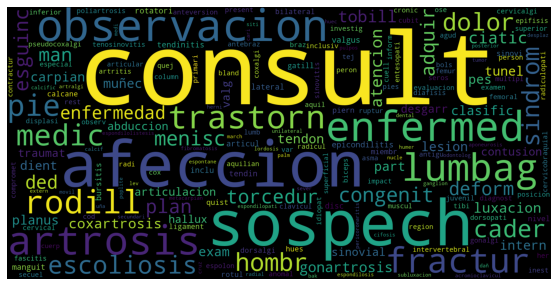


DK10_crudo: TRAUMATOLOGIA


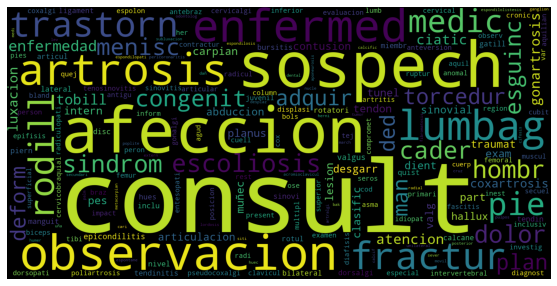


DK10_procesado: OFTALMOLOGIA


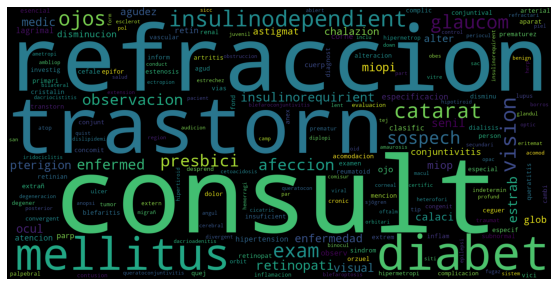


DK10_crudo: OFTALMOLOGIA


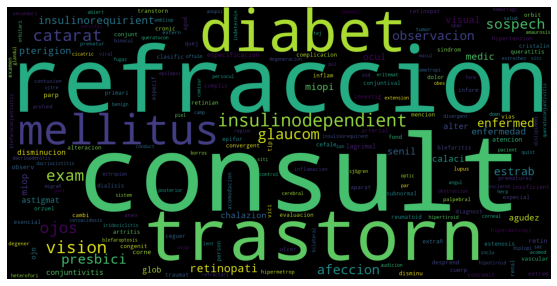


DK10_procesado: CIRUGIA ADULTO


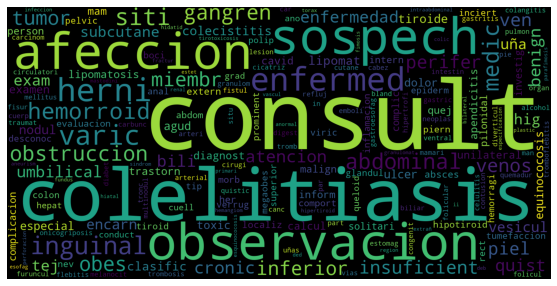


DK10_crudo: CIRUGIA ADULTO


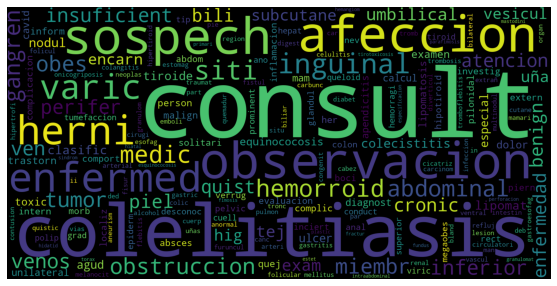


DK10_procesado: OTORRINOLARINGOLOGIA


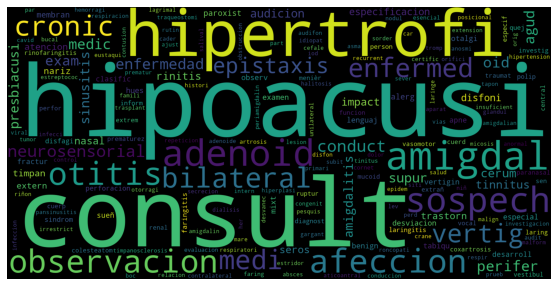


DK10_crudo: OTORRINOLARINGOLOGIA


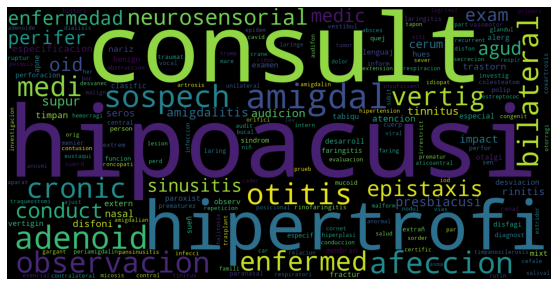


DK10_procesado: NEUROLOGIA


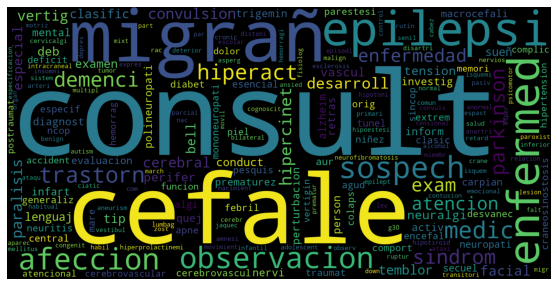


DK10_crudo: NEUROLOGIA


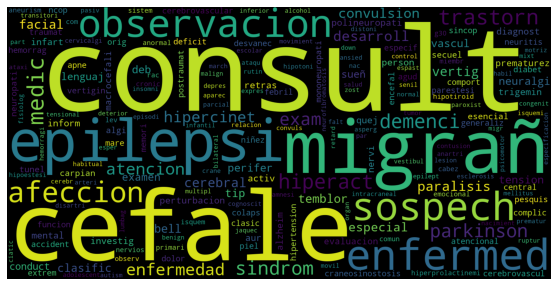


DK10_procesado: MEDICINA INTERNA


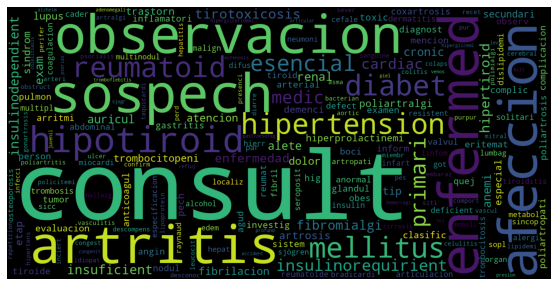


DK10_crudo: MEDICINA INTERNA


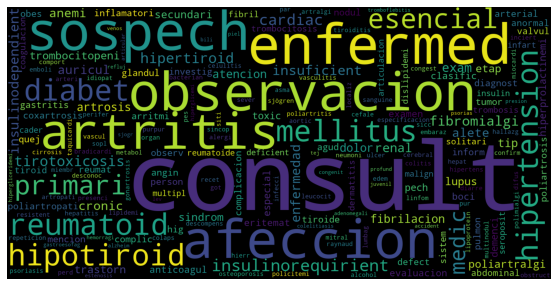


DK10_procesado: GINECOLOGIA


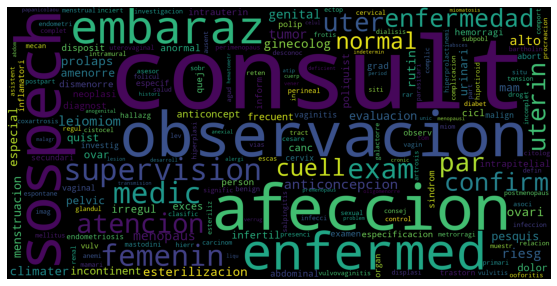


DK10_crudo: GINECOLOGIA


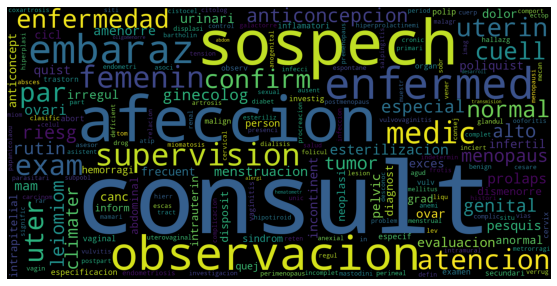


DK10_procesado: ENDODONCIA


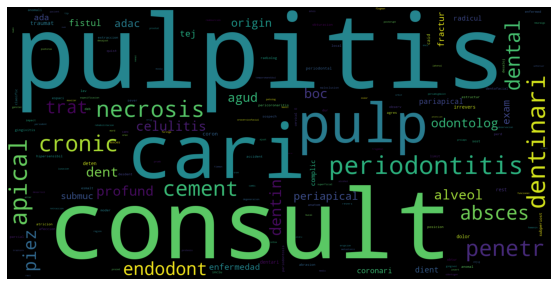


DK10_crudo: ENDODONCIA


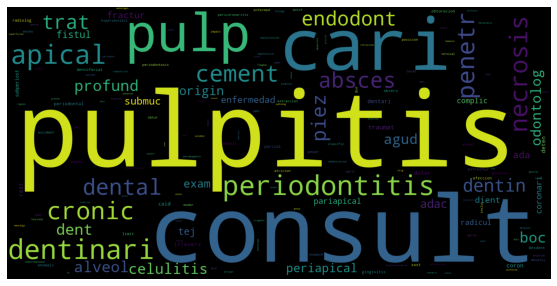

In [ ]:
for specialty in list(D10K_ranking.index):
  print(f"DK10_procesado: {specialty}")
  plot_wordcloud_from_specialty(DK10_procesado, specialty)
  print(f"")
  print(f"DK10_crudo: {specialty}")
  plot_wordcloud_from_specialty(DK10_crudo, specialty)
  print(f"")

# 3. Análisis supervisado (2 pts)


Utilice en esta sección la salida de la sección de limpieza, o el texto crudo.


**En esta parte volví a calcular el D10K porque creo que así es mejor**


In [ ]:
aysen_data = aysen[["SOSPECHA_DIAG","PRESTA_EST"]]

In [ ]:
rank = json.loads(aysen_data.PRESTA_EST.value_counts().to_json())
rank = pd.DataFrame(list(rank.items()),columns = ['PRESTA_EST','PRESTA_EST_COUNT'])
rank = rank.loc[rank['PRESTA_EST_COUNT'] > 10000]
rank

,PRESTA_EST,PRESTA_EST_COUNT
0,TRAUMATOLOGIA,24004
1,OFTALMOLOGIA,21482
2,CIRUGIA ADULTO,17321
3,OTORRINOLARINGOLOGIA,13663
4,NEUROLOGIA,12316
5,MEDICINA INTERNA,11408
6,GINECOLOGIA,10871
7,ENDODONCIA,10225


In [ ]:
rank_list = rank.PRESTA_EST.values.tolist()
rank_list

['TRAUMATOLOGIA',
 'OFTALMOLOGIA',
 'CIRUGIA ADULTO',
 'OTORRINOLARINGOLOGIA',
 'NEUROLOGIA',
 'MEDICINA INTERNA',
 'GINECOLOGIA',
 'ENDODONCIA']

In [ ]:
D10K = aysen_data.loc[aysen_data['PRESTA_EST'].isin(rank_list)]
D10K

,SOSPECHA_DIAG,PRESTA_EST
0,Celulitis y absceso de boca,ENDODONCIA
4,Celulitis y absceso de boca,ENDODONCIA
6,FISURA ANAL,CIRUGIA ADULTO
7,Periodontitis apical aguda originada en la pulpa,ENDODONCIA
8,"Osteomielitis, no especificada",TRAUMATOLOGIA
...,...,...
217886,HIPERTENSION ESENCIAL (PRIMARIA),MEDICINA INTERNA
217888,Consulta no Especificada,MEDICINA INTERNA
217889,HERNIAS DEL NUCLEO PULPOSO,NEUROLOGIA
217892,Consulta no Especificada,CIRUGIA ADULTO


## 3.1 Probabilidad de cada categoría en D10K

In [ ]:
total = rank.PRESTA_EST_COUNT.sum()
rank['PROB'] = rank.PRESTA_EST_COUNT/total
rank

,PRESTA_EST,PRESTA_EST_COUNT,PROB
0,TRAUMATOLOGIA,24004,0.197906
1,OFTALMOLOGIA,21482,0.177113
2,CIRUGIA ADULTO,17321,0.142806
3,OTORRINOLARINGOLOGIA,13663,0.112647
4,NEUROLOGIA,12316,0.101542
5,MEDICINA INTERNA,11408,0.094056
6,GINECOLOGIA,10871,0.089628
7,ENDODONCIA,10225,0.084302


## 3.2 Diccionario P(palabra|categoria).

In [ ]:
train_aysen, test_aysen = train_test_split(D10K, test_size=0.1)

In [ ]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words=stopwords_aysen)
term_doc_matrix_train = count_vectorizer.fit_transform(train_aysen.SOSPECHA_DIAG)
term_doc_matrix_train

<109161x4278 sparse matrix of type '<class 'numpy.int64'>'
	with 303199 stored elements in Compressed Sparse Row format>

In [ ]:
p_word_category = {}
for index, row in rank.iterrows():
  category = row['PRESTA_EST']
  count_c = row['PRESTA_EST_COUNT']
  # Se obtienen las apariciones de cada una de las palabras en cada clase
  c_w = np.asarray(term_doc_matrix_train.todense()[train_aysen.PRESTA_EST == category,:].sum(0)).reshape(-1)
  # Se calcula la probabilidad
  p_w = (c_w + 1) / count_c
  p_word_category[category] = p_w
p_word_category

{'CIRUGIA ADULTO': array([1.73200162e-04, 5.77333872e-05, 5.77333872e-05, ...,
        5.77333872e-05, 5.77333872e-05, 5.77333872e-05]),
 'ENDODONCIA': array([9.7799511e-05, 9.7799511e-05, 9.7799511e-05, ..., 9.7799511e-05,
        9.7799511e-05, 9.7799511e-05]),
 'GINECOLOGIA': array([9.19878576e-05, 9.19878576e-05, 9.19878576e-05, ...,
        4.59939288e-04, 1.06705915e-02, 9.19878576e-05]),
 'MEDICINA INTERNA': array([8.76577840e-05, 1.75315568e-04, 8.76577840e-05, ...,
        8.76577840e-05, 1.75315568e-04, 8.76577840e-05]),
 'NEUROLOGIA': array([8.11951932e-05, 8.11951932e-05, 8.11951932e-05, ...,
        8.11951932e-05, 8.11951932e-05, 8.11951932e-05]),
 'OFTALMOLOGIA': array([4.65506005e-05, 4.65506005e-05, 4.65506005e-05, ...,
        4.65506005e-05, 4.65506005e-05, 4.65506005e-05]),
 'OTORRINOLARINGOLOGIA': array([7.31903681e-05, 7.31903681e-05, 1.46380736e-04, ...,
        7.31903681e-05, 1.46380736e-04, 1.46380736e-04]),
 'TRAUMATOLOGIA': array([4.16597234e-05, 4.16597234e

## 3.3 Construya un clasificador Bayesiano Naive. Reporte el resultado de 3 métricas de clasificación ¿Detecto alguna categoría de mayor dificultad? ¿puede sugerir alguna interpretación a su resultado?


Nuestra matriz de términos y documentos tiene la forma (documentos,términos)

In [ ]:
# term_doc_matrix_train se construyo en el 3.2
term_doc_matrix_train

<109161x4278 sparse matrix of type '<class 'numpy.int64'>'
	with 303199 stored elements in Compressed Sparse Row format>

In [ ]:
term_doc_matrix_train.shape

(109161, 4278)

### Clasificador

In [ ]:
c_w_negative = np.asarray(term_doc_matrix_train.todense()[train_aysen.PRESTA_EST != 'TRAUMATOLOGIA', :].sum(0)).reshape(-1)
c_w_positive = np.asarray(term_doc_matrix_train.todense()[train_aysen.PRESTA_EST == 'TRAUMATOLOGIA', :].sum(0)).reshape(-1)
c_negative = (train_aysen.PRESTA_EST != 'TRAUMATOLOGIA').sum()
c_positive = (train_aysen.PRESTA_EST == 'TRAUMATOLOGIA').sum()
p_w_negative = (c_w_negative + 1) / c_negative # Probabilidad asociada a cada palabra en la clase negativa
p_w_positive = (c_w_positive + 1) / c_positive
r = np.log(p_w_positive / p_w_negative)
term_doc_matrix_test = count_vectorizer.transform(test_aysen.SOSPECHA_DIAG)
test_pred = term_doc_matrix_test.dot(r) > 0
test_label = np.where(test_aysen.PRESTA_EST == 'TRAUMATOLOGIA', True, False)
confusion_matrix = pd.crosstab(test_label,test_pred)


In [ ]:
confusion_matrix

col_0,False,True
row_0,,
False,8538,1156
True,587,1848


In [ ]:
def binary_naive_bayes(count_vectorizer, train_matrix, specialty):
  c_w_negative = np.asarray(train_matrix.todense()[train_aysen.PRESTA_EST != specialty, :].sum(0)).reshape(-1)
  c_w_positive = np.asarray(train_matrix.todense()[train_aysen.PRESTA_EST == specialty, :].sum(0)).reshape(-1)
  c_negative = (train_aysen.PRESTA_EST != specialty).sum()
  c_positive = (train_aysen.PRESTA_EST == specialty).sum()
  p_w_negative = (c_w_negative + 1) / c_negative # Probabilidad asociada a cada palabra en la clase negativa
  p_w_positive = (c_w_positive + 1) / c_positive
  r = np.log(p_w_positive / p_w_negative)
  term_doc_matrix_test = count_vectorizer.transform(test_aysen.SOSPECHA_DIAG)
  test_pred = term_doc_matrix_test.dot(r) > 0
  test_label = np.where(test_aysen.PRESTA_EST == specialty, True, False)
  confusion_matrix = pd.crosstab(test_label,test_pred)
  return (np.array(confusion_matrix).diagonal().sum() / np.array(confusion_matrix).sum())

In [ ]:
print(f"{binary_naive_bayes(count_vectorizer, term_doc_matrix_train, 'TRAUMATOLOGIA')}")

0.8562948305713579


In [ ]:
for specialty in rank_list:
  print(f"specialty: {specialty}: {binary_naive_bayes(count_vectorizer, term_doc_matrix_train, specialty)}")
  

specialty: TRAUMATOLOGIA: 0.8562948305713579
specialty: OFTALMOLOGIA: 0.9195317008821832
specialty: CIRUGIA ADULTO: 0.7181136120042872
specialty: OTORRINOLARINGOLOGIA: 0.9186247835765521
specialty: NEUROLOGIA: 0.8348586033473493
specialty: MEDICINA INTERNA: 0.6830736251958117
specialty: GINECOLOGIA: 0.6959353615302168
specialty: ENDODONCIA: 0.9604254266633688


## 3.4 ¿Cómo varía su resultado al utilizar bigramas?

In [ ]:
count_vectorizer_bigrams = sklearn.feature_extraction.text.CountVectorizer(stop_words=stopwords_aysen, ngram_range=(1, 2))
term_doc_matrix_train_bigrams = count_vectorizer_bigrams.fit_transform(train_aysen.SOSPECHA_DIAG)
print(f"{binary_naive_bayes(count_vectorizer_bigrams, term_doc_matrix_train_bigrams, 'TRAUMATOLOGIA')}")

0.8573666419325583


In [ ]:
for specialty in rank_list:
  print(f"specialty (with bigrams): {specialty}: {binary_naive_bayes(count_vectorizer_bigrams, term_doc_matrix_train_bigrams, specialty)}") 

specialty (with bigrams): TRAUMATOLOGIA: 0.8573666419325583
specialty (with bigrams): OFTALMOLOGIA: 0.9211806414378761
specialty (with bigrams): CIRUGIA ADULTO: 0.7231428806991508
specialty (with bigrams): OTORRINOLARINGOLOGIA: 0.9079066699645478
specialty (with bigrams): NEUROLOGIA: 0.8282628411245775
specialty (with bigrams): MEDICINA INTERNA: 0.681342237612334
specialty (with bigrams): GINECOLOGIA: 0.6906587517519993
specialty (with bigrams): ENDODONCIA: 0.9530876411905351
